In [1]:
# initial set-up
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sewar.full_ref import rmse, uqi
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

torch.manual_seed(0)
np.random.seed(0)

c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#  CONFIGURATIONS - HYPER PARAMETERS
################################################################
#  configurations - HYPER PARAMETERS
################################################################

batch_size = 10
learning_rate = 0.001

epochs = 100
step_size = 50
gamma = 0.5

modes = 16
width = 64

weight_decay=1e-4

# Hyperparameters to change - epoch{10,100,200}, step_size{}, batchsize{}, gamma{}, modes{}, weight_decay{}

In [3]:
#   DEFINING THE TOP FOURIER LAYER
#####################################################################
#   DEFINING THE TOP FOURIER LAYER
#####################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

In [4]:
# DIFFERENING MODELS WITH DIFFERING FOURIER LAYERS

#####################################################################
#  1 FOURIER LAYER
#####################################################################
class FNO1_1L(nn.Module):
    def __init__(self, modes, width):
        super(FNO1_1L, self).__init__()

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)


#####################################################################
#  2 FOURIER LAYER
#####################################################################
class FNO1_2L(nn.Module):
    def __init__(self, modes, width):
        super(FNO1_2L, self).__init__()

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)




#####################################################################
#  4 FOURIER LAYER
#####################################################################

class FNO2d_4L(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d_4L, self).__init__()        
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)



#####################################################################
# 6 FOURIER LAYER
#####################################################################
class FNO1_6L(nn.Module):
    def __init__(self, modes, width):
        super(FNO1_6L, self).__init__()

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv4 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv5 = SpectralConv1d(self.width, self.width, self.modes1)


        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.w4 = nn.Conv1d(self.width, self.width, 1)
        self.w5 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x1 = self.conv4(x)
        x2 = self.w4(x)
        x = x1 + x2


        x1 = self.conv5(x)
        x2 = self.w5(x)
        x = x1 + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)




#####################################################################
# 8 FOURIER LAYER
#####################################################################
class FNO1_8L(nn.Module):
    def __init__(self, modes, width):
        super(FNO1_8L, self).__init__()

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv4 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv5 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv6 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv7 = SpectralConv1d(self.width, self.width, self.modes1)



        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.w4 = nn.Conv1d(self.width, self.width, 1)
        self.w5 = nn.Conv1d(self.width, self.width, 1)
        self.w6 = nn.Conv1d(self.width, self.width, 1)
        self.w7 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x1 = self.conv4(x)
        x2 = self.w4(x)
        x = x1 + x2


        x1 = self.conv5(x)
        x2 = self.w5(x)
        x = x1 + x2

        x1 = self.conv6(x)
        x2 = self.w6(x)
        x = x1 + x2

        x1 = self.conv7(x)
        x2 = self.w7(x)
        x = x1 + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)




In [5]:
raw_data = scipy.io.loadmat('./datasets/training_data_16x16_10k')

sol = np.asarray(raw_data['solution_data'])
mes = np.asarray(raw_data['measurement_data'])

sol_temp = np.expand_dims(sol,axis = 1 )
#sol_temp = np.sqeeze(sol_temp)
mes_temp = np.transpose(np.expand_dims(mes,axis = 1 ),(0,2,1))


def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y

# we are solving the inverse problem, so going from measurements, to solutions
X, y = convert_data(mes_temp, sol_temp)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

#batch_size = 10

#train_loader = DataLoader(data_utils.TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
ntrain = 8000
ntest = 2000

In [7]:
# TRAINING AND EVALUATION
################################################################
# TRAINING AND EVALUATION
################################################################


def train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma):
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_losses, test_losses, epoch_time = [], [], []

    myloss = LpLoss(size_average=False)
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_mse = 0
        train_l2 = 0
        total_time = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            #print('in: ',x.shape)
            out = model(x)
            #print('out: ',out.shape)

            mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            l2.backward() # use the l2 relative loss

            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        #train_mse /= len(train_loader)
        train_l2 /= ntrain
        train_losses.append(train_l2)
        test_l2 /= ntest
        test_losses.append(test_l2)


        t2 = default_timer()
        epoch_time.append(t2 - t1)

        print(ep, t2 - t1, train_l2, test_l2)
    total_time = sum(epoch_time)
    print("TOTAL TIME: ", total_time, sep="---")

    output = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "epoch_time": epoch_time,
    "training_time": total_time,
    "model": model
    }
    return output 
# torch.save(model, 'model/ns_fourier_burgers')

# scipy.io.savemat('pred/burger_test.mat', mdict={'pred': pred.cpu().numpy()})

In [8]:
# MODEL METRICS
###################################
# MODEL METRICS
###################################
def model_metrics(model,test_loader,ntrain):
    rms_values, psnr_values, ssim_values, uqi_values = [], [], [], []

    for test_num in range(ntest):
        K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
        model.eval()
        predicted_np = np.reshape(model(K).detach().cpu().numpy(),(16,16))

        truth = test_loader.dataset[test_num][1]
        truth_np = np.reshape(truth.numpy(),(16,16))

        #diff_image = predicted - truth_np
        #np.sqrt(np.sum(diff_image**2)/256)

        rms_values.append(rmse(predicted_np, truth_np))
        psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        uqi_values.append(uqi(predicted_np, truth_np))

    model_rms = sum(rms_values)/ len(rms_values)
    std_rms = np.std(np.array(rms_values))

    model_psnr = sum(psnr_values)/ len(psnr_values)
    std_psnr = np.std(np.array(psnr_values))

    model_ssim = sum(ssim_values)/ len(ssim_values)
    std_ssim = np.std(np.array(ssim_values))

    model_uqi = sum(uqi_values)/ len(uqi_values)
    std_uqi = np.std(np.array(uqi_values))


    print("RMSE: ", model_rms, std_rms, sep="---")
    print("PSNR: ", model_psnr, std_psnr, sep="---")
    print("SSIM: ", model_ssim, std_ssim, sep="---")
    print("UQI: ", model_uqi, std_uqi, sep="---")


    output = {
    "rms": rms_values,
    "psnr": psnr_values,
    "ssim": ssim_values,
    "uqi": uqi_values,
    }
    return output 

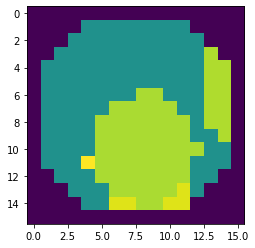

In [9]:
#Actual
test_num = 434
truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))

144002
0 5.3905890000169165 1.6837567244768143 0.7607434301376342
1 1.7113465999718755 1.2706949682831765 0.6310855305194855
2 1.7096285999868996 0.8090912868976593 0.7191653058528901
3 1.8602397000067867 0.6928838359713554 0.7577410230636596
4 1.8047917000076268 0.7008604464530945 0.6533919696807862
5 1.7667005999828689 0.6973225303888321 0.5682682752609253
6 1.745587199984584 0.6705251295566559 0.5156613082885743
7 1.724752999987686 0.6391557497382164 0.5168564925193787
8 1.7636724000039976 0.5766154074668884 0.565042191028595
9 1.754718000011053 0.6157612931728363 0.7042083134651184
10 1.8066997000132687 0.5513832587599754 0.5614344980716706
11 1.8035890999890398 0.5298238949179649 0.5388074440956115
12 1.7731262000161223 0.5316722220778465 0.48920339703559873
13 1.7805073000199627 0.5160743546485901 0.48789998769760135
14 1.769066999986535 0.5086829540729523 0.5057367532253265
15 1.7780450999853201 0.5051182231903076 0.5076851232051849
16 1.7883680000086315 0.5031859120726585 0.483

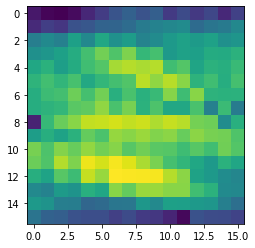

In [10]:
# ONE LAYER RESULTS
############################################################################

model_1L = FNO1_1L(modes, width).cuda()
print(count_params(model_1L))
output_1L = train_model(model_1L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_1L_model = output_1L.get("model")
torch.save(output_1L_model, 'fno1_1l.h5')
results_1L = model_metrics(output_1L_model,test_loader,ntrain)

# ONE LAYER RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_1L_model.eval()
predicted = np.reshape(output_1L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)

279234
0 9.106321300001582 0.2609807772487402 0.17020273661613464
1 4.208037800010061 0.15307909786701202 0.1443658378124237
2 4.233151699998416 0.14493380524218083 0.15036042422056198
3 4.170041499979561 0.14160164055228233 0.13674884554743766
4 4.259774000005564 0.138371366687119 0.13773244351148606
5 4.171877499989932 0.13656446355581284 0.13111641839146615
6 4.185374399996363 0.1335538504719734 0.13220510163903237
7 4.167069800023455 0.13217060383409263 0.1300633925497532
8 4.291156399995089 0.1313081597685814 0.12848189103603364
9 4.2025451000081375 0.12944459034502506 0.1280494778752327
10 4.189971799991326 0.1290146569237113 0.1261695058643818
11 4.150289300014265 0.12703247871249915 0.1255175274014473
12 4.2009983000170905 0.12599038685113192 0.12650243720412255
13 4.224406799999997 0.12537141797691584 0.12178224581480027
14 4.160706399998162 0.1235887546390295 0.12251620841026306
15 4.159042600018438 0.1232437065243721 0.12055965349078178
16 4.173868499987293 0.121611029833555

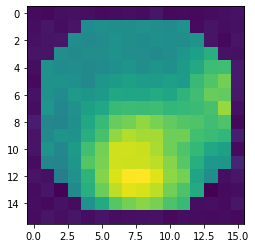

In [11]:
# TWO LAYER RESULTS
############################################################################

model_2L = FNO1_2L(modes, width).cuda()
print(count_params(model_2L))
output_2L = train_model(model_2L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_2L_model = output_2L.get("model")
torch.save(output_2L_model, 'fno1_2l.h5')


results_2L = model_metrics(output_2L_model,test_loader,ntrain)

# TWO LAYER RESULTS
############################################################################
output_2L_model.eval()
predicted = np.reshape(output_2L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)

549698
0 6.404017799999565 0.18449390682578087 0.15109824335575103
1 6.199470699997619 0.14443238405883313 0.14396299344301225
2 6.237803800002439 0.13769646862149237 0.13518560633063317
3 6.206661400006851 0.13230391158908605 0.1284161661863327
4 6.258401600003708 0.12885837510973214 0.12540512272715568
5 6.194368799973745 0.12713882322609424 0.13105934834480285
6 6.339502399991034 0.1244605615362525 0.12430596435070038
7 6.259577599994373 0.12424768628925086 0.1259360540509224
8 6.197749199985992 0.12155753980576992 0.12433938312530518
9 6.3388437000103295 0.12134084083884955 0.12068328127264977
10 6.187165100011043 0.11906310987472535 0.1199188358783722
11 6.255617999995593 0.1176935795545578 0.11526108887791633
12 6.2237403000181075 0.11664791383594275 0.11469886565208436
13 6.254057799989823 0.11484709335118533 0.11396812295913697
14 6.242013600014616 0.11315433244407178 0.11670295163989067
15 6.236995000013849 0.11181135468184948 0.11131675300002099
16 6.280872900009854 0.1107889

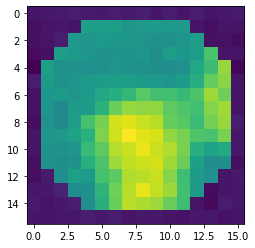

In [12]:
# FOUR LAYER RESULTS
############################################################################

model_4L = FNO1_4L(modes, width).cuda()
print(count_params(model_4L))
output_4L = train_model(model_4L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_4L_model = output_4L.get("model")
torch.save(output_4L_model, 'fno1_4l.h5')


results_4L = model_metrics(output_4L_model,test_loader,ntrain)

# FOUR LAYER RESULTS
############################################################################
output_4L_model.eval()
predicted = np.reshape(output_4L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)

820162
0 8.334174999996321 0.1944724222421646 0.1452626613974571
1 8.145089199999347 0.14303136382251977 0.13941806083917618
2 8.082685400004266 0.13644619077444076 0.13133250653743744
3 8.193100200005574 0.13183627954125404 0.13373710790276527
4 8.122195100004319 0.12843080496788026 0.1246140518784523
5 8.113878300006036 0.12644807436317204 0.13115922701358795
6 8.157747699995525 0.12524397820234298 0.12256593054533005
7 8.21518400000059 0.12307948318123818 0.1221008380651474
8 8.279461099999025 0.1214543874040246 0.1263821978867054
9 8.340252499998314 0.12042500338703394 0.11819556325674058
10 8.31819020002149 0.11936251091957092 0.12064940279722214
11 8.317054699989967 0.11858418937027454 0.11650421983003616
12 8.192944300011732 0.11749739966541528 0.11763650634884834
13 8.060389700025553 0.11646292595565319 0.11705405107140542
14 8.254359499987913 0.11459202242642641 0.11601061928272248
15 8.21769660001155 0.11423906745761633 0.11536124923825264
16 8.059573000005912 0.1131728444248

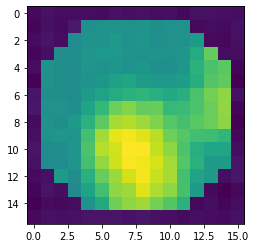

In [13]:
# SIX LAYER RESULTS
############################################################################

model_6L = FNO1_6L(modes, width).cuda()
print(count_params(model_6L))
output_6L = train_model(model_6L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_6L_model = output_6L.get("model")
torch.save(output_6L_model, 'fno1_6l.h5')


results_6L = model_metrics(output_6L_model,test_loader,ntrain)

# SIX LAYER RESULTS
############################################################################
output_6L_model.eval()
predicted = np.reshape(output_6L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)

1090626
0 10.422043899976416 0.19451672023534775 0.14492493569850923
1 10.257803599990439 0.14783211312443018 0.13622976765036582
2 10.16716070001712 0.13828644032031298 0.13237658628821372
3 10.062135999993188 0.13354669811576605 0.12765995380282402
4 10.219370000006165 0.1298150615170598 0.13292837619781495
5 10.240936999995029 0.12829487758874894 0.13141003659367562
6 10.121634100010851 0.1264157769754529 0.13023789966106414
7 10.187588100001449 0.1244572140276432 0.12751986432075502
8 10.195110899978317 0.12359631526470184 0.12102750942111015
9 10.399986100004753 0.12231433493643999 0.12018359875679016
10 10.156233599991538 0.12091872810572386 0.12875349709391595
11 10.380066899990197 0.11991866211593151 0.12033808681368828
12 10.26049369998509 0.11863358943164348 0.11639658871293068
13 10.531012999999803 0.11699010615050792 0.12493280881643296
14 9.936706600012258 0.11622034214437008 0.12068713703751564
15 10.139544800011208 0.11465766655653716 0.11514144334197045
16 10.0946145999

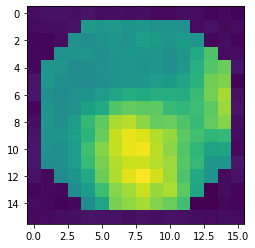

In [14]:
# EIGHT LAYER RESULTS
############################################################################

model_8L = FNO1_8L(modes, width).cuda()
print(count_params(model_8L))
output_8L = train_model(model_8L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_8L_model = output_8L.get("model")
torch.save(output_8L_model, 'fno1_8l.h5')


results_8L = model_metrics(output_8L_model,test_loader,ntrain)

# EIGHT LAYER RESULTS
############################################################################
output_8L_model.eval()
predicted = np.reshape(output_8L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)

In [15]:
''' 
One Layer
144002
TOTAL TIME: ---39.073271700006444
RMSE: ---0.01265196177334401---0.002670271925675282
PSNR: ---10.749582805589087---1.7174541600157496
SSIM: ---0.284687322717583---0.07086855525430798
UQI: ---0.907548633596253---0.057670149980738404


Two Layers
279234
TOTAL TIME: --- 88.78457890002755
RMSE: ---0.003158811306540759---0.0014685497455065371
PSNR: ---24.71717780169559---3.1661043424866926
SSIM: ---0.8448236801383773---0.04552967450139212
UQI: ---0.9923488872787619---0.005677528797604667


Four Layers
549698
TOTAL TIME: --- 125.05501619999995
RMSE: ---0.0029248563892472937---0.0013724690240738302
PSNR: ---25.392143863793912---3.281997302834296
SSIM: ---0.8731085960563277---0.04375513687360756
UQI: ---0.9934156493888673---0.00482059550424276

SIX LAYERS
820162
TOTAL TIME: ---163.8720632000477
RMSE: ---0.0030005403392746517---0.0013890247881787083
PSNR: ---25.219707683154038---3.1605086180064412
SSIM: ---0.8667007541307281---0.04393800171047696
UQI: ---0.993108352823714---0.004953352099787523



EIGHT LAYERS
1090626
TOTAL TIME: --- 204.37235229992075
RMSE: ---0.0029498494149794103---0.0014104242757421977
PSNR: ---25.23802341267495---3.378959858100774
SSIM: ---0.8680572058835299---0.0449140282654318
UQI: ---0.9934188000289267---0.005030645969928413

'''


' \nOne Layer\n144002\nTOTAL TIME: ---39.073271700006444\nRMSE: ---0.01265196177334401---0.002670271925675282\nPSNR: ---10.749582805589087---1.7174541600157496\nSSIM: ---0.284687322717583---0.07086855525430798\nUQI: ---0.907548633596253---0.057670149980738404\n\n\nTwo Layers\n279234\n()TOTAL TIME: ---4.11846680000599\nRMSE: ---0.003158811306540759---0.0014685497455065371\nPSNR: ---24.71717780169559---3.1661043424866926\nSSIM: ---0.8448236801383773---0.04552967450139212\nUQI: ---0.9923488872787619---0.005677528797604667\n\n\nFour Layers\n549698\nTOTAL TIME: --- 125.05501619999995\nRMSE: ---0.0029248563892472937---0.0013724690240738302\nPSNR: ---25.392143863793912---3.281997302834296\nSSIM: ---0.8731085960563277---0.04375513687360756\nUQI: ---0.9934156493888673---0.00482059550424276\n\nSIX LAYERS\n820162\nTOTAL TIME: ---7.934657399993739\nRMSE: ---0.0030005403392746517---0.0013890247881787083\nPSNR: ---25.219707683154038---3.1605086180064412\nSSIM: ---0.8667007541307281---0.0439380017104

<function matplotlib.pyplot.show(close=None, block=None)>

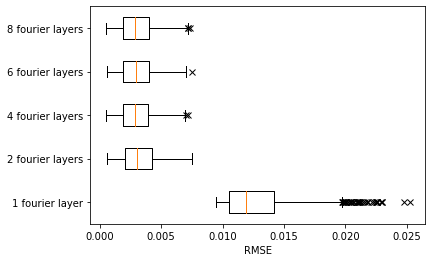

In [16]:
fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (results_1L.get("rms"), results_2L.get("rms"), results_4L.get("rms"), results_6L.get("rms"), results_8L.get("rms"))
labels = ('1 fourier layer', '2 fourier layers', '4 fourier layers', '6 fourier layers', '8 fourier layers')

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.yticks(np.arange(len(labels))+1,labels)
plt.xlabel('RMSE')
plt.show

[0.000483480059892079, 0.006965591655010221]

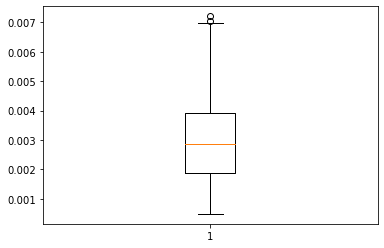

In [48]:
# Obtaining whisker values 
B = plt.boxplot(results_4L.get("rms"))
[item.get_ydata()[1] for item in B['whiskers']]

In [75]:
L = results_4L.get("rms")
next(x[0] for x in enumerate(L) if x[1] > 0.006965591655010221)


326

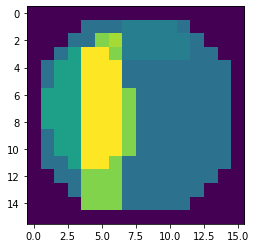

In [77]:
truth_out = test_loader.dataset[326][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))

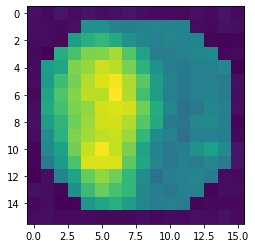

In [84]:
K = torch.unsqueeze(test_loader.dataset[326][0], 0).cuda()
output_4L_model.eval()
predicted = np.reshape(output_4L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)

In [89]:
rmse(predicted, np.reshape(truth_out.numpy(),(16,16)))

0.007205825841706953

<function matplotlib.pyplot.show(close=None, block=None)>

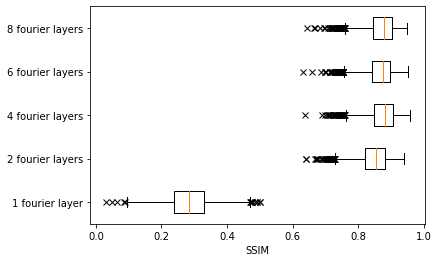

In [17]:
fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (results_1L.get("ssim"), results_2L.get("ssim"), results_4L.get("ssim"), results_6L.get("ssim"), results_8L.get("ssim"))
labels = ('1 fourier layer', '2 fourier layers', '4 fourier layers', '6 fourier layers', '8 fourier layers')

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.yticks(np.arange(len(labels))+1,labels)
plt.xlabel('SSIM')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

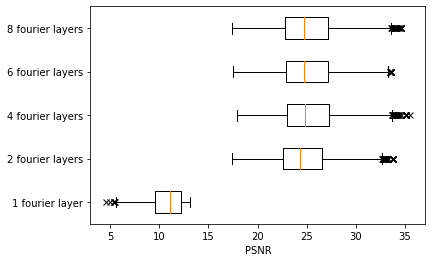

In [18]:
fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (results_1L.get("psnr"), results_2L.get("psnr"), results_4L.get("psnr"), results_6L.get("psnr"), results_8L.get("psnr"))
labels = ('1 fourier layer', '2 fourier layers', '4 fourier layers', '6 fourier layers', '8 fourier layers')

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.yticks(np.arange(len(labels))+1,labels)
plt.xlabel('PSNR')
plt.show

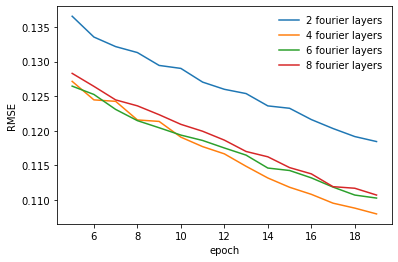

In [43]:
#plt.plot(output_1L.get('train_losses')[5:20], label='1 fourier layer')
plt.plot(range(5,20),output_2L.get('train_losses')[5:20], label='2 fourier layers')
plt.plot(range(5,20),output_4L.get('train_losses')[5:20],label='4 fourier layers')
plt.plot(range(5,20),output_6L.get('train_losses')[5:20], label='6 fourier layers')
plt.plot(range(5,20),output_8L.get('train_losses')[5:20], label='8 fourier layers')
#plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend(frameon=False)

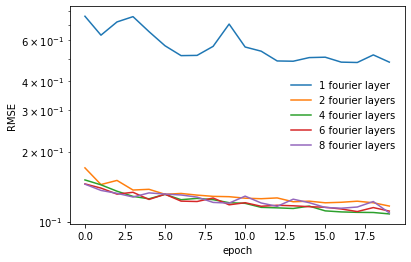

In [36]:
plt.plot(output_1L.get('test_losses'), label='1 fourier layer')
plt.plot(output_2L.get('test_losses'), label='2 fourier layers')
plt.plot(output_4L.get('test_losses'), label='4 fourier layers')
plt.plot(output_6L.get('test_losses'), label='6 fourier layers')
plt.plot(output_8L.get('test_losses'), label='8 fourier layers')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend(frameon=False)